The research question for today is: Can we predict the popularity of a movie (i.e. the IMDB rating of movie) solely on the basis of its poster? Opposed to the lab session on Tuesday, however, we are going to try the predict this on the basis of interpretable image features. That is, we are not going to use the
embeddings of some large pretrained neural network to answer this question, but features we can understand, like: What colors are used? Is the poster light or dark? How many people are on the posts? How many objects? Do the people on the poster look happy or sad?

In [2]:
import pandas as pd
import numpy as np
import os
import io
import urllib.request
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image
import cv2
%config InlineBackend.figure_format='retina' 

In [3]:
path = '/Users/jaspervogelzang/Documents/ADS Master/Data Mining/Lab Sessions/MovieGenre.csv'

def get_movie_poster_sample(csv_path, output_dir, sample_size=500):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    df = pd.read_csv(csv_path, sep=',', engine='python').dropna()
    sample = df.sample(sample_size, random_state=42)
    def_rows = []
    output_paths = []
    for row in tqdm(sample.itertuples(), total=sample_size):
        poster = row.Poster
        poster = poster[:poster.rfind('@')]
        poster_high_res = poster + '@._V1_FMjpg_UX500_.jpg'
        try:
            output_path = os.path.join(output_dir, str(row.imdbId) + '.jpg')
            if not os.path.isfile(output_path):
                urllib.request.urlretrieve(poster_high_res, output_path)
        except:
            continue
        output_paths.append(output_path)
        def_rows.append(row)
    final_sample_df = pd.DataFrame(def_rows)
    final_sample_df['Path'] = output_paths
    final_sample_df = final_sample_df.rename(columns={'_4': 'IMDB_rating', '_2': 'Url'})
    return final_sample_df 

df = get_movie_poster_sample(path, 'movie_posters/')

In [4]:
test = df.Path.values[0]
test

'movie_posters/95022.jpg'

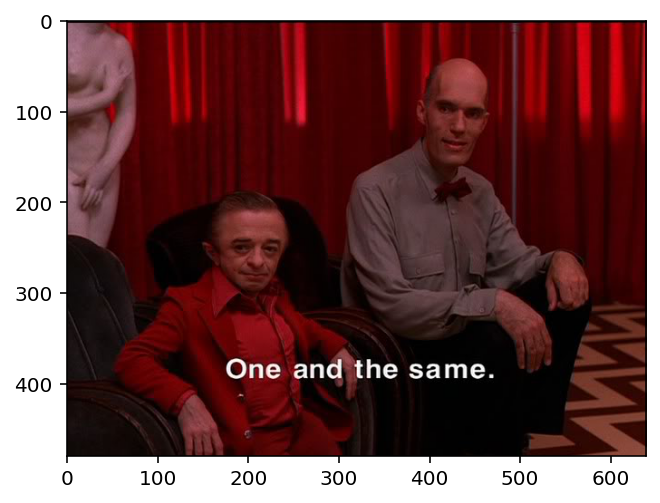

In [5]:
#Load and visualize image from url
def load_image_from_url(url, target_size=None, color_mode='rgb'):
    assert color_mode in ('grayscale', 'rgb'), 'color_mode must be "grayscale" or "rgb"'
    response = urllib.request.urlopen(url)
    img = Image.open(io.BytesIO(response.read()))
    img = img.convert('RGB')
    if color_mode == 'grayscale':
        img = ImageOps.grayscale(img)
    if target_size:
        img = img.resize(target_size, Image.NEAREST) # resize
    return image.img_to_array(img)

OUR_IMAGE = 'https://bakerbloch.files.wordpress.com/2014/12/pdvd_273.jpg'

color_image = load_image_from_url(OUR_IMAGE,
                        color_mode='rgb') # use from path if you downloaded it on your local computer
plt.imshow(color_image.astype(np.uint8))

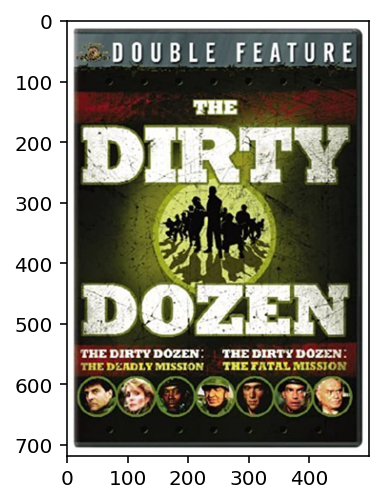

In [6]:
#Load and visualize image from path
def load_image_from_path(image_path, target_size=None, color_mode='rgb'):
    pil_image = image.load_img(image_path, 
                               target_size=target_size,
                            color_mode=color_mode)
    return image.img_to_array(pil_image)

color_image = load_image_from_path(test,
                        color_mode='rgb')
plt.imshow(color_image.astype(np.uint8))

# Object detection

In [7]:
#Loading pre-trained ResNet50 trained on ImageNet
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

object_classifier = ResNet50(weights='imagenet') # load the models, do this only once!!
INPUT_SHAPE_RESNET = object_classifier.input_shape[1:3]

In [8]:
color_image = load_image_from_path(test, color_mode='rgb', target_size=(INPUT_SHAPE_RESNET))
color_image = np.expand_dims(color_image, axis=0) # batch size of 1
color_image = preprocess_input(color_image) # specifically needed for ResNet50
preds = object_classifier.predict(color_image)

In [9]:
#Convert probabilities into class labels
for index, label, probability in decode_predictions(preds, top=5)[0]:
    print(label, probability)

web_site 0.5196074
scoreboard 0.24413854
slot 0.07493261
book_jacket 0.05107242
comic_book 0.018852327


If we want to know  where certain objects are located, or how many objects are in the picture. We have to use a model trained on the MS Coco (Common Objects in Context) task.

In [10]:
import tensorflow_hub as hub

INPUT_SHAPE = (224, 224) 
color_image = load_image_from_path(test, color_mode='rgb', target_size=(INPUT_SHAPE)).astype('uint8')
color_image_batched = np.expand_dims(color_image, axis=0) # batch size of one

#Load the model 
hub_model = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1") 

#Input the image to the model
results = hub_model(color_image_batched) 

OSError: SavedModel file does not exist at: /var/folders/h2/0skyhz8n5_lbmqwnjr6drbl00000gn/T/tfhub_modules/d652b89df9f8884ab75375063eab9a8c39c1804d/{saved_model.pbtxt|saved_model.pb}

In [12]:
#Load an overview from Github of the class labels
from urllib.request import urlopen

url_classes = 'https://raw.githubusercontent.com/nightrome/cocostuff/master/labels.txt'
coco_classes = [str(x)[str(x).find(' '):].strip().replace("'", '')
                for x in urlopen(url_classes).read().splitlines()]

We can now use these class labels to interpret are results. We do that by loading the detection scores (the probabilities for each label), the detection classes (the actual labels) and the detection boxes (the positions of the detected objects). We then only select the object that have a probability higher than 50% (or: 0.5) and print out the results:

In [13]:
detection_scores = results['detection_scores'].numpy()[0]
detection_clases = results['detection_classes'].numpy()[0]
detection_bounding_box = results['detection_boxes'].numpy()[0]

indices = np.where(detection_scores > 0.5) # only select labels with p > 0.50 
detection_classes_sel = detection_clases[indices] # get the classes where p > 0.5
detection_scores_sel = detection_scores[indices] # get the probabilities where p > 0.5
detection_bb_sel = detection_bounding_box[indices] # get the bounding boxes where p > 0.5

for i, label in enumerate(detection_classes_sel):
    textual_label = coco_classes[int(label)]
    probability =  detection_scores_sel[i] 
    bounding_box = detection_bb_sel[i]
    print('Label: {} \nProbability: {} \nBounding Box: {}'. format(textual_label,
                                                                     probability,
                                                                         bounding_box))
    print('*' * 50) 

Label: person 
Probability: 0.9757295250892639 
Bounding Box: [0.3790956  0.45439884 0.5390708  0.51391613]
**************************************************
Label: clock 
Probability: 0.9260683655738831 
Bounding Box: [0.17126171 0.00609331 0.9380261  0.83327454]
**************************************************
Label: clock 
Probability: 0.8886605501174927 
Bounding Box: [0.6002378 0.2481803 0.7303183 0.4197364]
**************************************************
Label: person 
Probability: 0.8253448605537415 
Bounding Box: [0.40105882 0.39904875 0.53078294 0.4564376 ]
**************************************************
Label: person 
Probability: 0.7819365859031677 
Bounding Box: [0.4193773  0.5555381  0.51571614 0.6163318 ]
**************************************************
Label: clock 
Probability: 0.7446691393852234 
Bounding Box: [0.36670753 0.24216354 0.6893577  0.6975771 ]
**************************************************
Label: person 
Probability: 0.6135643124580383 
Bound

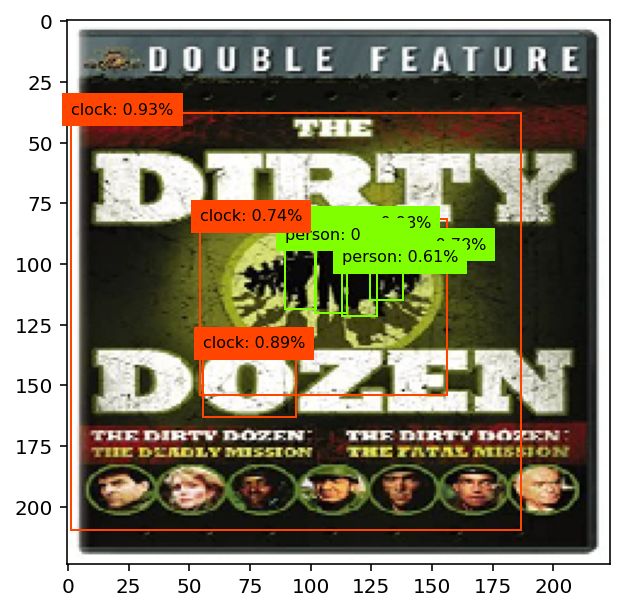

In [14]:
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]

def plot_coco_bounding_boxes(image,
                             detection_classes, 
                             detection_scores,
                             detection_bb,
                             target_size=(224, 224)):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    for i, label in enumerate(detection_classes):
        ymin, xmin, ymax, xmax = detection_bb[i]
        plt.axvspan(xmin * target_size[0], xmax * target_size[0], 1 - ymin , 1 - ymax , 
                    fill=False, color=STANDARD_COLORS[int(label)], label='chair')
        label_text = '{}: {}%'.format(coco_classes[int(label)], str(round(detection_scores[i], 2)))
        t = plt.text(xmin * target_size[0], ymin * target_size[0],
                     label_text,  fontsize=8, color='black')
        t.set_bbox(dict(facecolor=STANDARD_COLORS[int(label)], alpha=1, 
                        edgecolor=STANDARD_COLORS[int(label)]))

plot_coco_bounding_boxes(color_image,
                         detection_classes_sel,
                        detection_scores_sel,
                        detection_bb_sel, 
                        target_size=INPUT_SHAPE)

# Face detection

In [153]:
#Face detection
# !wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
pre_image = load_image_from_url(OUR_IMAGE, color_mode='grayscale')
gray_image = np.squeeze(pre_image).astype('uint8')

face_classification = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # load the classifier only once!

faces = face_classification.detectMultiScale(gray_image, 1.3, 5) # detect the faces 
n_faces = len(faces) # get the number of faces
print('Detected {} faces!'.format(n_faces))

Detected 2 faces!


# Gender classification

In [158]:
#wget https://github.com/oarriaga/face_classification/raw/master/trained_models/gender_models/gender_mini_XCEPTION.21-0.95.hdf5
from tensorflow.keras.models import load_model

def apply_offsets(face_coordinates, offsets):
    """
    Derived from https://github.com/oarriaga/face_classification/blob/
    b861d21b0e76ca5514cdeb5b56a689b7318584f4/src/utils/inference.py#L21
    """
    x, y, width, height = face_coordinates
    x_off, y_off = offsets
    return (x - x_off, x + width + x_off, y - y_off, y + height + y_off)

gender_classifier = load_model('gender_mini_XCEPTION.21-0.95.hdf5') # load this only once! (not in a loop)

GENDER_OFFSETS = (10, 10)
INPUT_SHAPE_GENDER = gender_classifier.input_shape[1:3]

labels = ['woman', 'man']

for face_coordinates in faces: # using the output of the CascadeClassifier
    x1, x2, y1, y2 = apply_offsets(face_coordinates, GENDER_OFFSETS) # extends the bounding box
    face_img = gray_image[y1:y2, x1:x2] # only get the face 
    face_img = cv2.resize(face_img, (INPUT_SHAPE_GENDER)) # resize the image
    face_img = face_img.astype('float32') / 255.0 # preprocess the image
    face_img = np.expand_dims(face_img, 0) # batch of one
    probas = gender_classifier.predict(face_img) 
    print((labels[np.argmax(probas[0])]), probas[0][np.argmax(probas[0])]) # print the class and the probabilitys

man 0.96312124
man 0.9902436


# Emotion recognition

In [33]:
#wget https://github.com/oarriaga/face_classification/raw/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5      

emotion_classifier = load_model('fer2013_mini_XCEPTION.102-0.66.hdf5') # load this only once! (not in a loop)

EMOTION_OFFSETS = (0, 0)
INPUT_SHAPE_EMOTION = emotion_classifier.input_shape[1:3]

labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

for face_coordinates in faces:
    x1, x2, y1, y2 = apply_offsets(face_coordinates, EMOTION_OFFSETS) 
    face_img = gray_image[y1:y2, x1:x2] # only get the face
    face_img = cv2.resize(face_img, (INPUT_SHAPE_EMOTION))
    face_img = face_img.astype('float32') / 255.0 # pre-processing 
    face_img = face_img - 0.5 # pre-processing specific to the emotion classifier
    face_img = face_img * 2.0 # pre-processing specific to the emotion classifier
    face_img = np.expand_dims(face_img, 0) # batch of one
    face_img = np.expand_dims(face_img, -1) # pre-processing specific to the emotion classifier
    probas = emotion_classifier.predict(face_img)
    label = labels[np.argmax(probas[0])]
    emotionprobas = dict(zip(labels, probas[0])) # make a dictionary from the labels and the probabilities
    print('This person looks {}'.format(label))
    print(emotionprobas)

This person looks happy
{'angry': 0.031301744, 'disgust': 0.00015423175, 'fear': 0.011305648, 'happy': 0.76841575, 'sad': 0.039529026, 'surprise': 0.009858767, 'neutral': 0.13943481}
This person looks happy
{'angry': 0.006935484, 'disgust': 3.4934867e-05, 'fear': 0.0020668872, 'happy': 0.45854983, 'sad': 0.17520149, 'surprise': 0.00017342033, 'neutral': 0.35703793}


# Extract text

In [76]:
import re
import pytesseract
from PIL import Image

color_image = load_image_from_url(OUR_IMAGE,
                        color_mode='rgb')
img = Image.fromarray(color_image.astype(np.uint8))

image_text = pytesseract.image_to_string(img,
                        config='--psm 12 --oem 1',
                            lang="eng"
                           )

cleaned_text = re.sub('[^\w\s]', '', image_text).replace('\n', ' ').strip()
print(cleaned_text)

3  a andthe _ file


# Color analysis

In [112]:
import colorgram
from matplotlib.colors import to_hex

color_image = load_image_from_url(OUR_IMAGE,
                        color_mode='rgb')
img = Image.fromarray(color_image.astype(np.uint8)) # convert to PIL image object

colors = colorgram.extract(img, 10) 

In [113]:
for i, color in enumerate(colors):
    rgb = tuple(color.rgb)
    hsv = tuple(color.hsl)
    proportion = color.proportion
    hex_code = to_hex([c/255 for c in rgb])
    print('#{}:'.format(i), rgb, hsv, hex_code, proportion)

#0: (46, 7, 6) (1, 196, 26) #2e0706 0.46523435202791447
#1: (67, 5, 7) (253, 219, 36) #430507 0.3038016453322356
#2: (117, 73, 79) (249, 59, 95) #75494f 0.07102764654761205
#3: (135, 21, 28) (252, 186, 78) #87151c 0.06773436836361973
#4: (123, 63, 56) (4, 95, 89) #7b3f38 0.04412273995517482
#5: (104, 41, 36) (3, 123, 70) #682924 0.031652062546148364
#6: (162, 102, 116) (245, 62, 132) #a26674 0.0056750240134867585
#7: (1, 3, 1) (85, 127, 2) #010301 0.004384503296545325
#8: (244, 238, 236) (10, 68, 240) #f4eeec 0.00385522644554656
#9: (2, 2, 5) (170, 109, 3) #020205 0.00251243147171636


(0.46523435202791447, 1.0, 0.46523435202791447, 1.0)

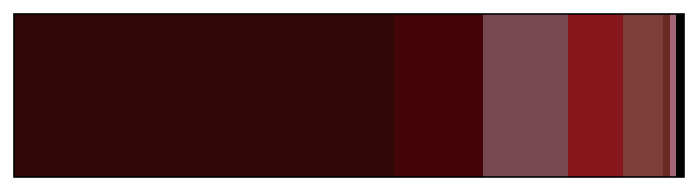

In [114]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6, 1.5))

norm_colors = [[color / 255 for color in tuple((color.rgb))]  for color in colors] # normalize our colors

cmap = mpl.colors.ListedColormap(norm_colors) # make a colormap
bounds = np.cumsum([color.proportion for color in colors]) # cumulative sum of the proportion
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, 
                                  norm=norm,
                                    spacing='proportional',
                                orientation='horizontal')
plt.axis('off')

In [115]:
import webcolors

def get_colour_name(rgb_triplet):
    """
    From https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python
    """
    min_colours = {}
    for key, name in webcolors.CSS21_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - rgb_triplet[0]) ** 2
        gd = (g_c - rgb_triplet[1]) ** 2
        bd = (b_c - rgb_triplet[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

for color in colors:
    rgb = tuple(color.rgb)
    proportion = color.proportion
    hex_code = to_hex([c/255 for c in rgb])
    color_name = get_colour_name(rgb)
    #print(color_name, rgb, hex_code, proportion)
    print(color_name, proportion)

black 0.46523435202791447
maroon 0.3038016453322356
gray 0.07102764654761205
maroon 0.06773436836361973
maroon 0.04412273995517482
maroon 0.031652062546148364
gray 0.0056750240134867585
black 0.004384503296545325
white 0.00385522644554656
black 0.00251243147171636


# Median RGB/HSV

In [59]:
median_r, median_g, median_b = np.median(color_image, axis=(0,1))
print(median_r, median_g, median_b)

70.0 3.0 4.0


In [60]:
#The hue, saturation and the lightness of the image:
color_image_hsv = cv2.cvtColor(color_image, cv2.COLOR_RGB2HSV)
median_h, median_s, median_v = np.median(color_image_hsv, axis=(0,1))
print(median_h, median_s, median_v)

12.0 0.939759 70.0


# Aspect ratio

In [61]:
color_image = load_image_from_url(OUR_IMAGE,
                        color_mode='rgb')

width = color_image.shape[1] 
height = color_image.shape[0]

aspect_ratio =  width / height
print(aspect_ratio)

1.3333333333333333


# Get the relevant features for all images
Save the features to a new dataframe

In [72]:
data = pd.DataFrame()
data['Path'] = df['Path']
data['IMDB_rating'] = df['IMDB_rating']
data[:5]

,Path,IMDB_rating
0,movie_posters/95022.jpg,5.2
1,movie_posters/96126.jpg,8.9
2,movie_posters/94155.jpg,6.5
3,movie_posters/3317326.jpg,7.0
4,movie_posters/94947.jpg,7.7


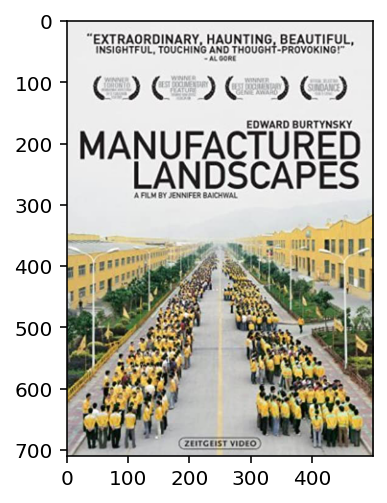

In [75]:
#Check if path in new dataset coresponds to the actual location of the images
check = data.Path.values[10]
color_image = load_image_from_path(check,
                        color_mode='rgb')
plt.imshow(color_image.astype(np.uint8))

In [97]:
#Classifying the number of faces for each image
#Create an empty list
n_faces = []

#Load the classifier
#face_classification = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 

#Loop over images
for file in tqdm(data.Path):
    pre_image = load_image_from_path(file, color_mode='grayscale')
    gray_image = np.squeeze(pre_image).astype('uint8')
    faces = face_classification.detectMultiScale(gray_image, 1.3, 5)
    n_faces.append(len(faces))
data['n_faces'] = n_faces

In [126]:
#Classifying the dominant color for each image
dominant_color = []

for file in tqdm(data.Path):
    color_image = load_image_from_path(file,
                        color_mode='rgb')
    img = Image.fromarray(color_image.astype(np.uint8)) # convert to PIL image object
    colors = colorgram.extract(img, 1) 
    for color in colors:
        rgb = tuple(color.rgb)
        proportion = color.proportion
        hex_code = to_hex([c/255 for c in rgb])
        color_name = get_colour_name(rgb)
        dominant_color.append(color_name)
data['dominant_color'] = dominant_color

In [128]:
#Extract the text used in each image
text = []

for file in tqdm(data.Path):
    color_image = load_image_from_path(file,
                        color_mode='rgb')
    img = Image.fromarray(color_image.astype(np.uint8))
    image_text = pytesseract.image_to_string(img,
                        config='--psm 12 --oem 1',
                            lang="eng"
                           )
    cleaned_text = re.sub('[^\w\s]', '', image_text).replace('\n', ' ').strip()
    text.append(cleaned_text)
data['text'] = text

In [194]:
#Extract the hue, saturation and the lightness of the image
hue = []
saturation = []
lightness = []

for file in tqdm(data.Path):
    color_image = load_image_from_path(file,
                                       color_mode='rgb')
    img = Image.fromarray(color_image.astype(np.uint8))
    colors = colorgram.extract(img, 10) 
    color_image_hsv = cv2.cvtColor(color_image, cv2.COLOR_RGB2HSV)
    median_h, median_s, median_v = np.median(color_image_hsv, axis=(0,1))
    median_h = round(median_h)
    median_s = round(median_s, 2)
    median_v = round(median_v)
    hue.append(median_h)
    saturation.append(median_s)
    lightness.append(median_v)
data['hue'] = hue
data['saturation'] = saturation
data['lightness'] = lightness

In [195]:
data[:5]

,Path,IMDB_rating,n_faces,dominant_color,text,hue,saturation,lightness
0,movie_posters/95022.jpg,5.2,3,black,DOUBLE FEATURE THE DIRTY 9 DOZEN bt ag ar...,66,0.29,84
1,movie_posters/96126.jpg,8.9,1,olive,TERS s SUBTITLES 3 Ped ry x i i Pot...,30,0.61,170
2,movie_posters/94155.jpg,6.5,0,silver,SPECIAL EDITION PRTISS ITD HSH ea ee se t...,44,0.27,208
3,movie_posters/3317326.jpg,7.0,1,white,TYSON WitliaMs vanes UNDERWOOD aan PALMER...,60,0.11,224
4,movie_posters/94947.jpg,7.7,1,black,LUST SEDUCTION REVENGE THE GAME AS YOUVE NEVE...,19,0.74,110


In [196]:
data.to_csv('poster_features.csv')

In [2]:
range(0, 10)

range(0, 10)